# Decision trees

In [1]:
import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from pyadlml.pipeline import Pipeline
from sklearn.model_selection import cross_validate

## Pipeline + first example

In [2]:
from pyadlml.dataset import set_data_home, fetch_amsterdam, fetch_aras, fetch_uci_adl_binary

set_data_home('/home/chris/code/adlml/data_home')
data = fetch_amsterdam(cache=True)

In [3]:
from pyadlml.model_selection import train_test_split

print('splitting data in train and test set...')
X_train, X_test, y_train, y_test = train_test_split(
    data.df_devices,
    data.df_activities,
    split='leave_one_day_out')

splitting data in train and test set...


What we can notice that the dataset is very imbalanced. Therefore we use Undersampling from [link] to balance the samples

In [4]:
from imblearn.under_sampling import RandomUnderSampler as ImbRUS
from pyadlml.pipeline import XOrYTransformer

class RandomUnderSampler(ImbRUS, XOrYTransformer):
    
    def fit(self, X, y, *args):
        self.rus_ = ImbRUS(sampling_strategy=self.sampling_strategy)
        return self
    
    def fit_transform(self, X,y):
        self.fit(X,y)
        return self.transform(X, y)
    
    def transform(self, X, y):
        return self.rus_.fit_resample(X,y)
        

In [47]:
from pyadlml.dataset import ACTIVITY
class DropNanLabels(XOrYTransformer):
    def fit(self, X,y=None):
        return self

    def fit_transform(self, X, y):
        return self.transform(X,y)

    def transform(self, X, y):
        if isinstance(y, pd.DataFrame):
            nan_mask = y[ACTIVITY].isna().values
            return X[~nan_mask], y[~nan_mask]
        
        elif isinstance(y, np.ndarray):
            raise NotImplentedError
        return idx_to_drop

In [54]:
tmp2_y[ACTIVITY]

0

### Define the Pipeline

In [60]:
from pyadlml.preprocessing import StateVectorEncoder, LabelEncoder, DropTimeIndex, CVSubset, SequenceSlicer, DfCaster
from pyadlml.pipeline import Pipeline, TrainOnlyWrapper, EvalOnlyWrapper, TrainOrEvalOnlyWrapper

steps = [
    ('encode_devices', StateVectorEncoder(encode='changepoint')),
    ('fit_labels', TrainOrEvalOnlyWrapper(LabelEncoder(idle=False))),
    ('drop_nans', TrainOrEvalOnlyWrapper(DropNanLabels())),
    ('drop_time', DropTimeIndex()),
    ('df->np', DfCaster('df->np', 'df->np')),
    ('undersample', TrainOnlyWrapper(RandomUnderSampler(sampling_strategy='not minority'))),
    ('passthrough', 'passthrough')
]

pipe = Pipeline(steps).train()

### Transform training data and fit the Decision Tree

In [61]:
Xenc_train, yenc_train = pipe.fit_transform(X_train, y_train)

print('Xenc_train: ', type(Xenc_train), Xenc_train.shape, Xenc_train.dtype)
print('yenc_train: ', type(yenc_train), yenc_train.shape, yenc_train.dtype)

Xenc_train:  <class 'numpy.ndarray'> (735, 14) float32
yenc_train:  <class 'numpy.ndarray'> (735,) int64


In [62]:
dtc = DecisionTreeClassifier().fit(Xenc_train, yenc_train) 

### Transform test data and evaluate the Decision Tree

In [63]:
pipe.eval()
Xenc_test, yenc_test = pipe.transform(X_test, y_test)

print('Xenc_train: ', type(Xenc_test), Xenc_test.shape, Xenc_test.dtype)
print('yenc_train: ', type(yenc_test), yenc_test.shape, yenc_test.dtype)

Xenc_train:  <class 'numpy.ndarray'> (61, 14) float32
yenc_train:  <class 'numpy.ndarray'> (61,) int64


In [91]:
y_pred = dtc.predict(Xenc_test)
y_true = yenc_test

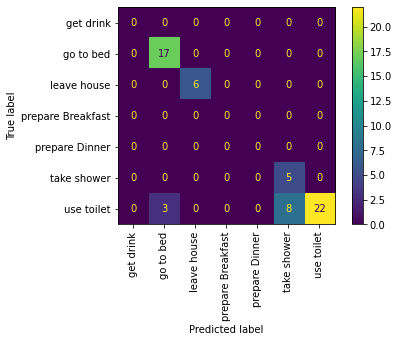

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = pipe['fit_labels'].wr.classes_ 

cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,len(labels)));
ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=labels                 
                       ).plot(xticks_rotation='vertical');

In [102]:
from sklearn.metrics import classification_report
cr = classification_report(y_true, y_pred, 
                           labels=np.arange(0,len(labels)),
                           target_names=pipe['fit_labels'].wr.classes_,
                           zero_division=0)
print(cr)

                   precision    recall  f1-score   support

        get drink       0.00      0.00      0.00         0
        go to bed       0.85      1.00      0.92        17
      leave house       1.00      1.00      1.00         6
prepare Breakfast       0.00      0.00      0.00         0
   prepare Dinner       0.00      0.00      0.00         0
      take shower       0.38      1.00      0.56         5
       use toilet       1.00      0.67      0.80        33

        micro avg       0.82      0.82      0.82        61
        macro avg       0.46      0.52      0.47        61
     weighted avg       0.91      0.82      0.83        61



## Parameter Tuning

In [20]:
from sklearn.tree import DecisionTreeClassifier
from pyadlml.model_selection import KFold, GridSearchCV

steps = [
    ('encode_devices', StateVectorEncoder(encode='changepoint')),
    ('fit_labels', TrainOrEvalOnlyWrapper(LabelEncoder(idle=False))),
    ('drop_nans', TrainOrEvalOnlyWrapper(DropNanLabels())),
    ('train_split', CVSplitter()),
    ('test_split', CVSplitter()),
    ('drop_time', DropTimeIndex()),
    ('df->np', DfCaster('df->np', 'df->np')),
    ('undersample', TrainOnlyWrapper(RandomUnderSampler(sampling_strategy='not minority'))),
    ('passthrough', 'passthrough')
]

pipe = Pipeline(steps).train()

# evaluate pipeline
n = 10
scoring_fcts = ['f1_macro', 'accuracy', 'recall']
param_grid = {
    'undersample__sampling_strategy' : ['not majority', 'not minority'],
    'classifier__max_depth' : [2,3,4],
    'classifier__min_samples_leaf': [1,2,3]
}

scores = np.zeros(n, dtype=np.float32)
best_param = (0.0, {})
for i in range(n):
    cv = KFold(n_splits=5)
    gscv = GridSearchCV(pipe, param_grid, refit='f1_macro', 
                        scoring=scoring_fcts, cv=cv, n_jobs=-1, online_split=True)
    gscv.fit(X_train, y_train)
    scores[i] = gscv.best_score_
    if scores[i] > best_param[0]:
        best_param = ((scores[i], gscv.best_params_))

IndexError: positional indexers are out-of-bounds

In [34]:
print('F1 mean Score: {:.4f}, std: {:.4f}'.format(scores.mean(), scores.std()))
print('F1 best Score: {:.4f}'.format(best_param[0]))

F1 mean Score: 0.1453, std: 0.0014
F1 best Score: 0.1469


In [35]:
best_pipe = Pipeline(steps=steps)
best_pipe = best_pipe.set_params(**best_param[1])
best_pipe = best_pipe.fit(X_train, y_train)
best_model = best_pipe.get_params()['model']

In [23]:
from sklearn import tree
import graphviz 
from IPython.display import display

dot_data = tree.export_graphviz(best_model, out_file=None)
graph = graphviz.Source(dot_data)
display(graph)#, width = 600, height = 300)

NameError: name 'best_model' is not defined

# Evaluation

In [51]:
from sklearn.dummy import DummyClassifier

def score_dummies(X_train, y_train, X_test, y_test, n=100):
    strats = ['stratified', 'most_frequent', 'uniform']
    means = {strats[0] : np.zeros(n), strats[1] : np.zeros(n), strats[2] : np.zeros(n)}

    for i in range(n):
        for strat in strats:
            dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)
            means[strat][i] = dclf.score(X_test, y_test)

    for strat in strats:
        std = means[strat].std()
        mean = means[strat].mean()
        means[strat] = {'std': std, 'mean':mean}
    return means

n = 100
score_dummies(X_train, y_train, X_test, y_test, n)

{'stratified': {'std': 0.037150667072824516, 'mean': 0.17054054054054057},
 'most_frequent': {'std': 5.551115123125783e-17, 'mean': 0.3693693693693693},
 'uniform': {'std': 0.03126775122808572, 'mean': 0.11522522522522523}}

### confusion matrix

In [60]:
y_true = y_test
y_pred = best_model.predict(X_test)

NameError: name 'best_model' is not defined

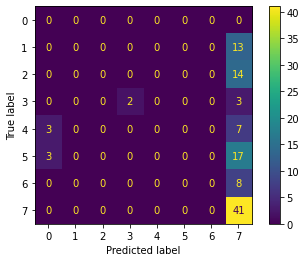

In [56]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_test, y_test);

In [28]:
from pyadlml.model_selection import LeaveOneDayOut

lodo = LeaveOneDayOut(num_days=1)
ts = lodo.split(X=raw, y=lbls)

X = raw
y = lbls

for train_index, test_index in ts:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
from sklearn.dummy import DummyClassifier

strat='stratified'

dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)
y_pred = dclf.predict(X_test)
y_true = enc_lbl.inverse_transform(y_test)

In [29]:
enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [61]:
from pyadlml.metrics import plot_true_vs_inf_y
plot_true_vs_inf_y(enc_lbl, y_true, y_pred, index=y_true.index)

NameError: name 'enc_lbl' is not defined

## Comparision over all Datasets

### Aras